# Set-up

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt

import seqdata as sd

from eugene import preprocess as pp

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
rbp = "AGGF1"

In [7]:
# Paths
data_dir = f"/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/processed/2023_12_29/encode/{rbp}/"
fasta = "/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa"
out_dir = f"/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2024_07_19/HepG2/{rbp}/"

In [8]:
# Make output directory if doesn't exist
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Positive strand

In [9]:
pos_peaks = os.path.join(data_dir, "peaks.crosslink.pos.bed")
pos_bw = [os.path.join(data_dir, "signal.pos.bw"), os.path.join(data_dir,"control.pos.bw")]
pos_names = ['signal', 'control']
pos_out = os.path.join(out_dir, "pos.zarr")

In [10]:
pos_sdata = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=2048,
        n_threads=4,
        alphabet="RNA"
    ),
    sd.BigWig(
        'cov',
        pos_bw,
        pos_names,
        batch_size=2048,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=pos_out,
    fixed_length=300,
    bed=pos_peaks,
    overwrite=True,
    max_jitter=32
)
pos_sdata.load()

100%|██████████| 24612/24612 [00:00<00:00, 83837.23it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 24612/24612 [00:03<00:00, 7594.71it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 24612, cov_sample: 2, _length: 364)
Coordinates:
  * cov_sample  (cov_sample) object 'signal' 'control'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM' 'chrM'
    chromEnd    (_sequence) int64 630049 630099 630149 632746 ... 2956 3006 3328
    chromStart  (_sequence) int64 629685 629735 629785 632382 ... 2592 2642 2964
    cov         (_sequence, cov_sample, _length) float32 0.0 0.0 0.0 ... 3.0 1.0
    name        (_sequence) object 'ENSG00000225630.1' ... 'ENSG00000210082.2'
    score       (_sequence) float64 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    seq         (_sequence, _length) |S1 b'G' b'C' b'A' b'C' ... b'T' b'A' b'C'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '+' '+' '+'
    thickEnd    (_sequence) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    thickStart  (_sequence) int64 27 114 93 21 94 ... 25119 24331 31525 22771
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [11]:
# Split cov and control
pos_sdata['signal'] = (
    pos_sdata.cov.sel(cov_sample=['signal'])
    .drop_vars("cov_sample").squeeze()
)
pos_sdata['control'] = (
    pos_sdata.cov.sel(cov_sample=['control'])
    .drop_vars("cov_sample").squeeze()
)
# Get rid of aggregated cov
pos_sdata = pos_sdata.drop_vars("cov")
pos_sdata = pos_sdata.drop_vars("cov_sample")

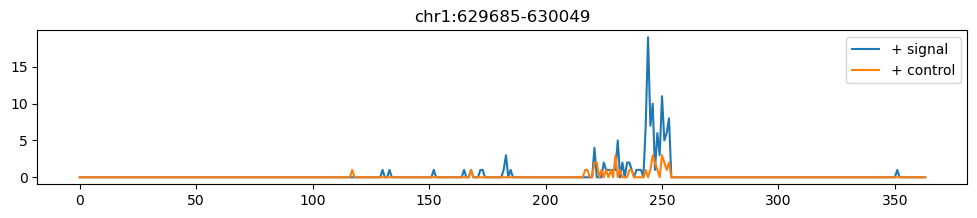

In [12]:
# Plot signal and control
seq_num = 0
ser = pos_sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(pos_sdata["signal"][seq_num].values, label="+ signal")
plt.plot(pos_sdata["control"][seq_num].values, label="+ control")
plt.title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
plt.legend()

# Negative strand

In [13]:
neg_peaks = os.path.join(data_dir, "peaks.crosslink.neg.bed")
neg_bw = [os.path.join(data_dir, "signal.neg.bw"), os.path.join(data_dir,"control.neg.bw")]
neg_names = ['signal', 'control']
neg_out = os.path.join(out_dir, "neg.zarr")

In [14]:
neg_sdata = sd.from_region_files(
    sd.GenomeFASTA(
        'seq',
        fasta,
        batch_size=2048,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        neg_bw,
        neg_names,
        batch_size=2048,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=neg_out,
    fixed_length=300,
    bed=neg_peaks,
    overwrite=True,
    max_jitter=32
)
neg_sdata.load()

100%|██████████| 23233/23233 [00:00<00:00, 40630.24it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 23233/23233 [00:03<00:00, 7631.17it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 23233, cov_sample: 2, _length: 364)
Coordinates:
  * cov_sample  (cov_sample) object 'signal' 'control'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM' 'chrM'
    chromEnd    (_sequence) int64 17680 1264129 1264179 ... 14577 14627 14677
    chromStart  (_sequence) int64 17316 1263765 1263815 ... 14213 14263 14313
    cov         (_sequence, cov_sample, _length) float32 0.0 0.0 0.0 ... 3.0 0.0
    name        (_sequence) object 'ENSG00000227232.5' ... 'ENSG00000198695.2'
    score       (_sequence) float64 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    seq         (_sequence, _length) |S1 b'A' b'G' b'A' b'G' ... b'A' b'G' b'T'
    strand      (_sequence) object '-' '-' '-' '-' '-' ... '-' '-' '-' '-' '-'
    thickEnd    (_sequence) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    thickStart  (_sequence) int64 15 35 41 38 40 48 ... 1181 1897 2043 1241 1193
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [15]:
# Split cov and control
neg_sdata['signal'] = (
    neg_sdata.cov.sel(cov_sample=['signal'])
    .drop_vars("cov_sample").squeeze()
)
neg_sdata['control'] = (
    neg_sdata.cov.sel(cov_sample=['control'])
    .drop_vars("cov_sample").squeeze()
)
# Get rid of aggregated cov
neg_sdata = neg_sdata.drop_vars("cov")
neg_sdata = neg_sdata.drop_vars("cov_sample")

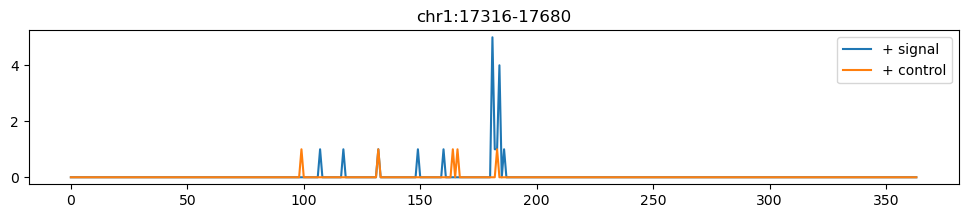

In [16]:
# Plot signal and control
seq_num = 0
ser = neg_sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(neg_sdata["signal"][seq_num].values, label="+ signal")
plt.plot(neg_sdata["control"][seq_num].values, label="+ control")
plt.title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
plt.legend()

# Full SeqData

In [18]:
# Concatenate them
sdata = xr.concat([pos_sdata, neg_sdata], dim="_sequence")

In [19]:
# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in [3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]]
valid_chroms = ["chr1", "chr8", "chr15"]
test_chroms = ["chr2", "chr9", "chr16"]
len(training_chroms), len(valid_chroms), len(test_chroms)

(16, 3, 3)

In [20]:
# Keep only autosomes
sdata = sdata.sel(_sequence=((sdata["chrom"].isin(training_chroms + valid_chroms + test_chroms))))
sdata["chrom"].to_series().value_counts()

chr2     4793
chr17    3861
chr16    3471
chr1     2935
chr7     2825
chr6     2784
chr20    2610
chr19    2560
chr12    2268
chr11    2258
chr3     2258
chr9     2218
chr14    1890
chr21    1711
chr22    1379
chr10    1350
chr4     1262
chr5     1139
chr8     1055
chr13     759
chr15     562
chr18     297
Name: chrom, dtype: int64

In [21]:
# Save full SeqData
sd.to_zarr(sdata, os.path.join(out_dir, 'both.zarr'), mode='w')

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/dataset.py:764: UserWarning: reset_encoding is deprecated since 2023.11, use `drop_encoding` instead
  warnings.warn(
/cellar/users/aklie/projects/ML4GLand/SeqData/seqdata/xarray/seqdata.py:228: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  sdata.to_zarr(


In [22]:
# Create split columns
pp.train_test_chrom_split(sdata, test_chroms=["chr1", "chr8", "chr15"], train_var="train_test")
pp.train_test_chrom_split(sdata, test_chroms=["chr2", "chr9", "chr16"], train_var="train_val")

In [23]:
# Split SeqDatas
train_sdata = sdata.sel(_sequence=(sdata["train_val"] & sdata["train_test"]))
valid_sdata = sdata.sel(_sequence=~sdata["train_val"])
test_sdata = sdata.sel(_sequence=~sdata["train_test"])

In [24]:
# Check how many of each
train_sdata.dims["_sequence"], valid_sdata.dims["_sequence"], test_sdata.dims["_sequence"]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


(31211, 10482, 4552)

In [25]:
# Save them
sd.to_zarr(train_sdata, os.path.join(out_dir, 'train.zarr'), mode='w')
sd.to_zarr(valid_sdata, os.path.join(out_dir, 'valid.zarr'), mode='w')
sd.to_zarr(test_sdata, os.path.join(out_dir, 'test.zarr'), mode='w')

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/dataset.py:764: UserWarning: reset_encoding is deprecated since 2023.11, use `drop_encoding` instead
  warnings.warn(
/cellar/users/aklie/projects/ML4GLand/SeqData/seqdata/xarray/seqdata.py:228: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  sdata.to_zarr(
/cellar/users/aklie/projects/ML4GLand/SeqData/seqdata/xarray/seqdata.py:228: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  sdata.to_zarr(
/cellar/users/aklie/opt/miniconda3/

# DONE!

----